# Revisiting the ringdown of GW150914: sample analysis

We analyze the GW150914 ringdown by assuming all modes are circularly polarized, corresponding to a face-off nonprecessing system. This is a special case of the "aligned" model, in which we assume the QNM initial conditions are symmetric under equatorial reflections (i.e., their excitation amplitudes satisfy $C_{\ell m n} = (-1)^\ell C_{\ell -m n}^*$), and thus the observed ellipticity of the modes depends only on the source inclination (see Appendix B in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

Although this more closely resembles the analysis carried out in [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), it is not meant to reproduce it exactly (e.g., it uses slightly different data, a different amplitude prior and an exponential parameterization of the Kerr deviations); the results are, nonetheless, consistent.

_(See licensing information at the end of this file.)_

This first cell must be executed first in order for Stan's multiprocessing code to not crash some MacOS setups; on linux it's not needed.

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import ringdown as rd

sns.set(context='notebook', palette='colorblind')

## Data

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 4096s of data in each IFO, sampled at 16 kHz.

In [4]:
!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

--2022-02-05 22:50:04--  https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517084465 (493M) [application/x-hdf]
Saving to: ‘H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5’

H-H1_GWOSC_16KHZ_R1 100%[===================>] 493.13M  20.3MB/s    in 25s     

2022-02-05 22:50:30 (19.6 MB/s) - ‘H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5’ saved [517084465/517084465]

--2022-02-05 22:50:30--  https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 20

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 9a853be0f769fd177d40880dbd56af62
MD5(L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 299f1ca9c089c4802d48f313ce2e6567
```

In [5]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 9a853be0f769fd177d40880dbd56af62
MD5(L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 299f1ca9c089c4802d48f313ce2e6567


Now we make timeseries data objects out of the stored data:

In [6]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

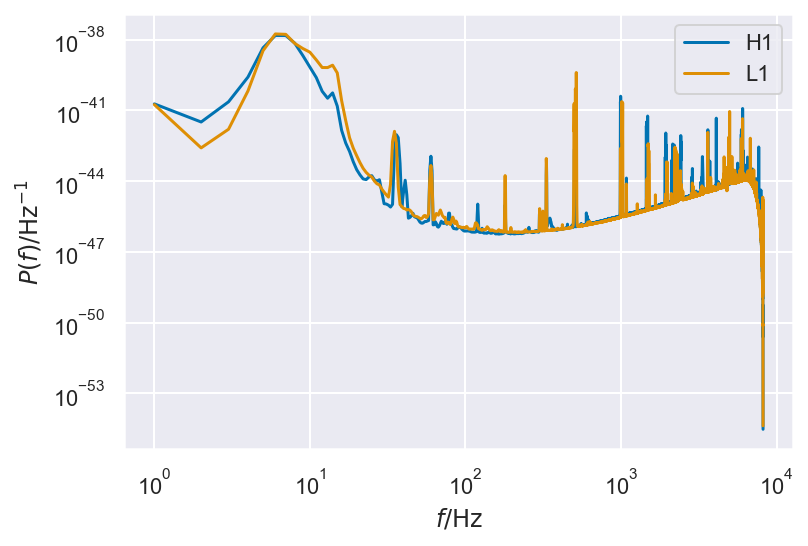

In [7]:
for i, s in raw_strain.items():
    s.get_psd(nperseg=int(s.fsamp)).iloc[1:].plot(label=i)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a short data segment (to eliminate low frequency content)---rhe `condition_data` method below accomplishes this. We will downsample to a sample rate of 2048 Hz, and a segment length of $\sim 0.2\, \mathrm{s}$.  We choose this duration based on the impulse response of the noise whitening filter, which is of order $\sim 0.2\, \mathrm{s}$. (See `ringdown` [example](https://github.com/maxisi/ringdown/blob/main/examples/GW150914.ipynb) for further exposition.)

In [8]:
T = 0.2
srate = 2048

M_est = 70.0
chi_est = 0.7

longest_tau = rd.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/rd.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 200.0 ms at sample rate 2048


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

Unlike in our other example, here we select the `mchi_aligned` model, which assumes the QNM excitations are symmetric under equatorial reflections, with observed ellipticity depending only on the cosine of the source inclination ($\cos \iota$).

Currently, this is only implemented for $\ell = |m| = 2$ modes: requesting a different angular harmonic will raise an error.
 The template is
$$
h_+ = \left(1+\cos^2\iota\right) \sum_n A_n e^{-t/\tau_n} \cos(\omega_n t - \phi_n)
$$
$$
h_\times = 2 \cos\iota \sum_n A_n e^{-t/\tau_n} \sin(\omega_n t - \phi_n)
$$

By construction, this is much more restrictive than our generic elliptical model (see Sec. II in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)), but it follows the model in [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract). **NOTE**, however, that the amplitudes presented in Fig. 2 of Isi et al. (2019) correspond to the amplitude of the plus polarization at the Hanford detector, defined by $A'_n = F_+ \left(1+\cos^2\iota\right) A_n 
\approx 1.1 \times A_n$ in terms of $A_n$ as defined above.

In the cell below, we create a `Fit` object for an `mchi_aligned` analysis including two tones: the fundamental and first overtone. We also set the analysis target, which specifies the truncation time and presumed source sky location.

In [9]:
fit = rd.Fit(model='mchi_aligned')

# specify we want two-tones (n=0,1), by default with `s=-2, l=2, m=2, p=1`
fit.set_tone_sequence(2)

# add data
for s in raw_strain.values():
    fit.add_data(s)

# set analysis target, offset by `dt0` seconds from the reference time in Isi et al (2019).
dt0M = 0
Mref = 69
dt0 = dt0M*Mref*rd.qnms.T_MSUN

fit.set_target(1126259462.4083147 + dt0, ra=1.95, dec=-1.27, psi=0.82, duration=T)

Having set the target, we can now condition the data. The `Fit` object will know to preserve the sample closest to the targeted truncation time, even after downsampling.

In [10]:
# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)

In [11]:
# compute autocovariance functions
fit.compute_acfs()

It is instructive to look at the whitened data segment in both interferometers:

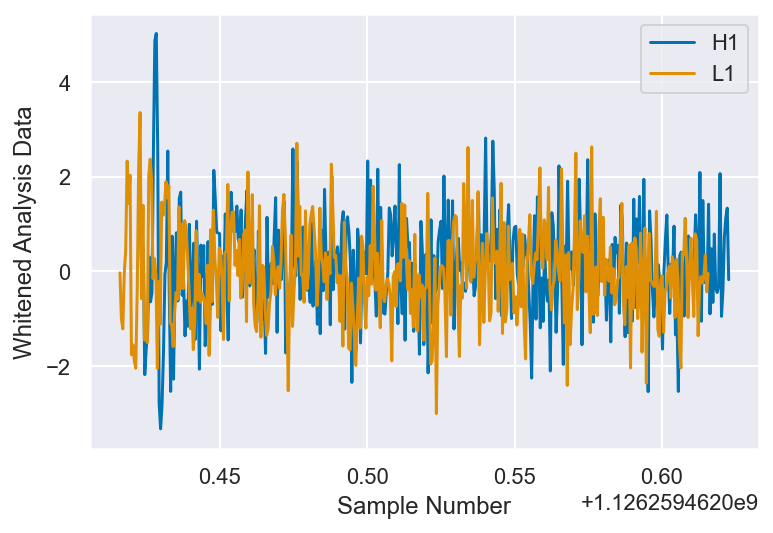

In [12]:
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [13]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

In [14]:
fit.antenna_patterns

{'H1': [0.578742411175002, -0.45094782109531206],
 'L1': [-0.5274334329518102, 0.20520960891727422]}

## Kerr fit

The `flat_A` option controls whether we place a Gaussian prior on the quadratures (`flat_A = 0`, default)---which is much faster to sample because it does not have weird linear structures in the quadratures---or (as in our paper) a flat prior on `A` (`flat_A > 0`).  We set `A_scale = 5e-21`, which controls the scale of the Gaussian prior (`flat_A=0`) and also lets the sampler see approximately unit-scale variables (both prior choices).

Instead of an ellipticity parameter for each individual mode, the `mchi_aligned` model has a global inclination parameter `cosi` corresponding to the cosine of the source inclination. This parameter determines the ellipticity for _all_ modes, assuming the signal has an $\ell=|m|=2$ angular dependence and that the intrinsic mode excitations were symmetric under equatorial reflections ("nonprecessing" symmetry). By default, the prior is uniform in `-1 < cosi < 1`, but we will restrict that range by setting `cosi_max = -0.99`; this follows the expectation that the GW150914 was nearly face off.

In [15]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=1)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [16]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'cosi_min': -1,
 'cosi_max': -0.99,
 'flat_A': 1}

Our fit is ready to go; run it! **NOTE:** Since we picked $T = 0.2\, \mathrm{s}$ this might take a while---if you are in a hurry you can reduce that significantly (say, to $T = 0.05\, \mathrm{s}$ and still get a decent result.

(The `run()` method will automatically compile the `PyStan` code the first time any fit runs in a given session, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.)

In [ ]:
fit.run()

Running mchi_aligned


ld: warning: -pie being ignored. It is only used when linking a main executable



Gradient evaluation took 0.010882 seconds
1000 transitions using 10 leapfrog steps per transition would take 108.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.011003 seconds
1000 transitions using 10 leapfrog steps per transition would take 110.03 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.01098 seconds
1000 transitions using 10 leapfrog steps per transition would take 109.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.011043 seconds
1000 transitions using 10 leapfrog steps per transition would take 110.43 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


Optionally, save the result to disk as a NetCDF object (JSON and other formats also available).

In [ ]:
# fit.result.to_netcdf('my_gw150914_fit.nc')

### Posteriors

We can plot a trace, and see visually that the sampling seems OK:

In [ ]:
az.plot_trace(fit.result, var_names=['A', 'M', 'chi'], compact=True);

The total mass and spin that we recover are reasonable given the full waveform analysis of GW150914 (remember that the total mass will be the *detector frame* total mass!).  Note the use of `ringdown.kdeplot_2d_clevels` which draws contours at credible levels of the KDE estimate of the posterior distribution (here at 0.9, 0.5 and 0.1 credible levels).

In [ ]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

The fundamental mode is about $240 \, \mathrm{Hz}$; we measure its frequency to better than ~5%.

In [ ]:
print('f0 = {:.2f} +-{:.2f}'.format(median(fit.result.posterior.f[:,:,0]), std(fit.result.posterior.f[:,:,0].values)))

We can make a similar plot for the recovered amplitudes:

In [ ]:
df = pd.DataFrame({
    r'$A_0$': fit.result.posterior.A.values[:,:,0].flatten(),
    r'$A_1$': fit.result.posterior.A.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot, alpha=0.1, marker='.');
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

We can obtain a measure of the overtone "significance" by computing the mean-to-standard-deviation ratio for the overtone amplitude.

In [ ]:
x = fit.result.posterior.A.values[:,:,1].flatten()
mean(x) / std(x)

This agrees with [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract).

### Reconstructions

Get median signal reconstructions at each detector:

In [ ]:
ms, mf, mo = {}, {}, {}

for i, ifo in enumerate(fit.ifos):
    # median reconstructed signal at each detector
    ms[ifo] = fit.result.posterior.h_det.median(axis=(0,1)).values[i,:] 

    # median reconstructed fundamental mode at each detector
    mf[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,0,:]

    # median reconstructed overtone at each detector
    mo[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,1,:]

Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

In [ ]:
# compute median and 90% CL for total reconstruction
hsamps = fit.result.posterior.h_det
h = median(hsamps, axis=(0,1))
ys = [percentile(hsamps, p, axis=(0, 1)) for p in [5, 95]]

# compute median and 90% CL for individual modes
hsamps_mode = fit.result.posterior.h_det_mode
h_mode = median(hsamps_mode, axis=(0,1))
ys_mode = [percentile(hsamps_mode, p, axis=(0, 1)) for p in [5, 95]]

# plot credible regions
for i, ifo in enumerate(ifos):
    t = fit.analysis_data[ifo].time
    l, = plot(t-t[0], h[i,:], label='all')
    fill_between(t-t[0], ys[0][i,:], ys[1][i,:], lw=0, 
                 color=l.get_color(), alpha=0.3)
    
    for n in range(fit.n_modes):
        l, = plot(t-t[0], h_mode[i,n,:], ls=':', label='$n=%i$' % n, zorder=-10)
        fill_between(t-t[0], ys_mode[0][i,n,:], ys_mode[1][i,n,:], lw=0, color=l.get_color(),
                     alpha=0.2, zorder=-10)
    xlim(-0.0005, 0.02);
    legend(title=ifo);
    xlabel('$t-t_0$ (s)');
    ylabel('strain')
    figure();

We may also plot the whitened residuals at each interferometer.

In [ ]:
# whiten reconstructions
hwhites = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    h = apply_along_axis(lambda x: acf.whiten(x), -1, hsamps[:,:,i,:])
    hwhites.append(h)

In [ ]:
# compute credible regions for whitened reconstructions
h = median(hwhites, axis=(0,1))
ys = [percentile(hwhites, p, axis=(0, 1)) for p in [5, 95]]

# plot credible regions for whitened reconstructions
for i, ifo in enumerate(ifos):
    d = fit.acfs[ifo].whiten(fit.analysis_data[ifo])
    h = median(hwhites[i], axis=(0,1))
    ys = [percentile(hwhites[i], p, axis=(0, 1)) for p in [5, 95]]
    t = fit.analysis_data[ifo].time
    
    l, = plot(t-t[0], h-d, label=ifo)
    fill_between(t-t[0], ys[0]-d, ys[1]-d, lw=0, 
                 color=l.get_color(), alpha=0.3)

legend();
xlim(-0.001, 0.04);
xlabel('$t-t_0$ (s)')
ylabel('Whitened residuals');

Let's look at the recovered, matched-filter SNR in the network.

In [ ]:
hsamps = fit.result.posterior.h_det

snrs_ifos = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    d = fit.analysis_data[ifo]
    snrs = apply_along_axis(lambda x: acf.compute_snr(x, d), -1, hsamps[:,:,i,:])
    snrs_ifos.append(snrs)

In [ ]:
snrs_net = linalg.norm(snrs_ifos, axis=0)

sns.histplot(snrs_net.flatten(), stat='density', kde=True);
xlabel('matched-filter network SNR post-$t_0$');

(We might add some code to make these operations a little easier in the future.)

## Beyond-Kerr fit

We can allow for perturbations to the frequency and damping rates of subsets of the ringdown modes as a spectroscopic test of GR.  First, we copy the fit object so that we are sure to use the same data, prior settings, etc, in the GR test as we did above:

In [ ]:
fit_testgr = fit.copy()

A reminder about the prior options we can set:

In [ ]:
print(fit_testgr.valid_model_options)

To test GR, we allow for perturbations of the overtone frequency and damping time.  The parameterization used here introduces $\delta f$ and $\delta \tau$ parameters and defines 
$$
f = f_{\mathrm{GR}} e^{\delta f}
$$
and
$$
\tau = \tau_{\mathrm{GR}} e^{\delta \tau}.
$$
Thus the perturbation is defined for all values $-\infty < \delta f, \delta \tau < \infty$ and for small values of the perturbation parameter is is the *relative* deviation of the frequency/damping time from the GR value.  By default we truncate $-1/2 < \delta f, \delta \tau < 1/2$ (corresponding to a factor of $\sqrt{e} \simeq 1.6$ change away from the GR value), but this can be changed in the prior settings as well. 

**NOTE:** this is different from Isi et al (2019), which used a parameterization like $f = f_{\mathrm{GR}} \left(1 + \delta f\right)$ instead; the numerical difference is small for small values of the perturbation.

In [ ]:
fit_testgr.update_prior(perturb_f=[0,1], perturb_tau=[0,1])
fit_testgr.prior_settings

In [ ]:
fit_testgr.run()

In [ ]:
az.plot_trace(fit_testgr.result, var_names=['M', 'chi', 'df', 'dtau', 'f', 'tau', 'A'],
              coords={'df_dim_0': 1, 'dtau_dim_0': 1});

You can see that we place a constraint on the $\delta f$ parameter; the 1-sigma range is about 25\%, and the posterior peaks noticeably around the GR value of $\delta f = 0$.  The posterior on $\delta \tau$ is nearly flat, with a modest preference for larger $\delta \tau$, but still fully consistent with GR.  In 2D (lower left plot) the GR value of $(0,0)$ is contained within the 50% credible contour.

In [ ]:
df = pd.DataFrame({
    r'$\delta f_1$': fit_testgr.result.posterior.df.values[:,:,1].flatten(),
    r'$\delta \tau_1$': fit_testgr.result.posterior.dtau.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_upper(sns.scatterplot, marker='.', alpha=0.5)
pg.map_diag(sns.kdeplot)
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

In [ ]:
df = fit_testgr.result.posterior.df.values[:,:,1].flatten()
print('1-sigma (68%) range of df in [{:.2f}, {:.2f}]'.format(quantile(df, 0.16), quantile(df, 0.84)))
print('std(df) = {:.2f}'.format(std(df)))

## License

Copyright 2022
Maximiliano Isi <max.isi@ligo.org>

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston,
MA 02110-1301, USA.